In [6]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

# 1. LeNet : 최초의 CNN
```
<img src='image/LeNet.png' alt='LeNet'>
```
![LeNet](image/LeNet.png)

FC(120) : 120개 출력층의 뉴런을 가진 Fully Connected 레이어

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense
                                            # AveragePooling2D 동일
from tensorflow.keras.callbacks import EarlyStopping, Callback
import pandas as pd # crosstab
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self, times=5): # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.\
                 format(self.epoch, 
                        logs.get('loss'), 
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))

In [5]:
# 출력사이즈 = (입력사이즈 - 커널사이즈)/스트라이드 + 1
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1), activation='relu'):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(6, # 커널 갯수
                        kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal',
                        padding='valid'
                        )) # C1층
        model.add(AvgPool2D(pool_size=(2,2),
                           strides=2, # 스트라이드 사이즈는 기본이 pool_size
                           # strides=(2,2)
                           )) # P2층
        model.add(Conv2D(16, kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal')) # C3층
        model.add(AvgPool2D(pool_size=(2,2), strides=2)) # P4층
        model.add(Flatten())
        model.add(Dense(120, activation='relu', kernel_initializer='he_normal')) #F5층
        model.add(Dense(84, activation='relu', kernel_initializer='he_normal')) # F6층
        model.add(Dense(10, activation='softmax')) # 출력층
        return model

In [7]:
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1), activation='relu'):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(6, kernel_size=(5,5), activation=activation, 
                   kernel_initializer='he_normal'),
            AvgPool2D(pool_size=(2,2), strides=2),
            Conv2D(16, kernel_size=(5,5), activation=activation, 
                   kernel_initializer='he_normal'),
            AvgPool2D(pool_size=(2,2), strides=2),
            Flatten(),
            Dense(120, activation='relu', kernel_initializer='he_normal'),
            Dense(84, activation='relu', kernel_initializer='he_normal'),
            Dense(10, activation='softmax') # 출력층
        ])
        return model

In [8]:
model = LeNet.build(input_shape=(28,28,1), activation='relu')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [10]:
#  1. 데이터
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train = X_train.reshape(-1, 28,28,1)/255.0
X_test = X_test.reshape(-1, 28,28,1)/255.0
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [11]:
# 2.모델생성
model = LeNet.build(input_shape=(28,28,1))
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', # 원핫인코딩을 안 하고 분류분석
             optimizer='adam',
             metrics=['accuracy'])
# 4. 학습
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=10)
hist = model.fit(X_train, y_train,
                validation_split=0.2, 
                epochs=50,
                callbacks=[customHistory, earlystopping],
                verbose=0)

epoch:3, loss:0.05270559713244438, acc:0.9830416440963745, val_loss:0.06439472734928131, val_acc:0.9806666374206543
epoch:6, loss:0.02859506756067276, acc:0.9907500147819519, val_loss:0.04393176734447479, val_acc:0.9869999885559082
epoch:9, loss:0.017610644921660423, acc:0.9944166541099548, val_loss:0.043879423290491104, val_acc:0.9881666898727417
epoch:12, loss:0.013784471899271011, acc:0.9952499866485596, val_loss:0.03657058626413345, val_acc:0.9901666641235352
epoch:15, loss:0.009218198247253895, acc:0.996874988079071, val_loss:0.061979543417692184, val_acc:0.987583339214325
epoch:18, loss:0.006933334283530712, acc:0.9976041913032532, val_loss:0.07147443294525146, val_acc:0.9864166378974915


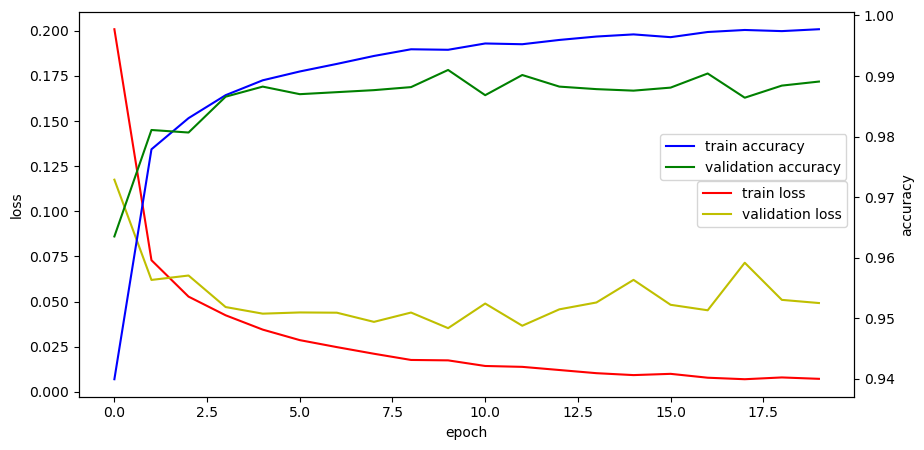

In [14]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print("accuracy : {:.2f}%".format(accuracy*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0432 - accuracy: 0.9898
accuracy : 98.98%


In [22]:
# 예측치와 실제값을 이용한 교차표
yhat = model.predict(X_test).argmax(axis=1)
display(pd.crosstab(y_test, yhat)) # 결과가 데이터프레임
# print(confusion_matrix(y_test, yhat)) # 결과가 넘파이배열
cnt = 0
for y, h in zip(y_test, yhat):
    if y!=h:
        cnt += 1
print('예측이 틀린 갯수 :', cnt)

313/313 [==============================] - 1s 2ms/step


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,0,1,0,0,0,1,1,0,3
1,0,1130,2,2,0,0,1,0,0,0
2,1,0,1024,0,0,0,0,5,2,0
3,0,0,1,1003,0,4,0,2,0,0
4,0,0,1,0,977,0,0,0,0,4
5,0,0,1,5,0,885,1,0,0,0
6,5,1,3,0,3,6,940,0,0,0
7,0,3,5,0,1,0,0,1010,1,8
8,1,0,2,1,1,1,0,0,967,1


예측이 틀린 갯수 : 102


i = 3423
cnt = 50


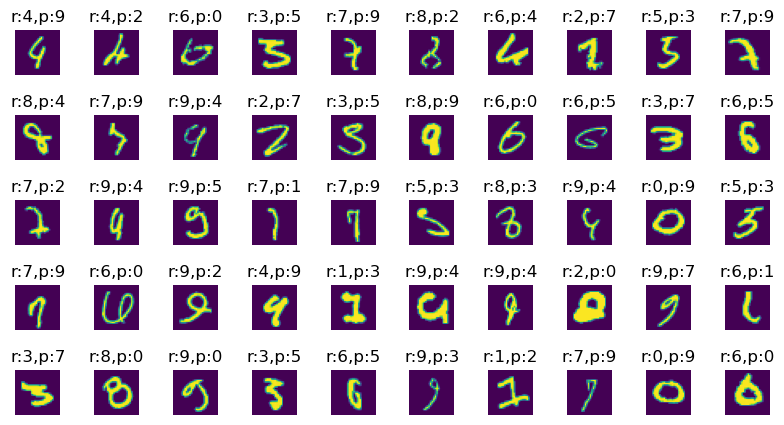

In [23]:
# 모델 학습 후 예측이 틀린 경우만 출력
plt_row = 5
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
# plt.rc('font', family='Malgun Gothic') # 윈도우즈 os
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.9, wspace=0.2)

i = 0 # yhat과 y_test를 액세스할 index
cnt = 0 # 출력할 횟수
while (cnt<plt_row*plt_col) & (i < len(y_test)):
    # 예측한 결과가 틀렸을 경우만 imshow(X_test[i]), 실제값과 예측치를 title에 출력
    if yhat[i]==y_test[i]:
        i += 1
        continue
    # 예측한 값과 실제값이 다른 경우
    sub_plot = axarr[cnt//plt_col, cnt%plt_col]
    sub_plot.imshow(X_test[i].reshape(28, 28))
    title = 'r:{},p:{}'.format(y_test[i], yhat[i])
    sub_plot.set_title(title)
    sub_plot.axis('off')
    i += 1
    cnt += 1
print('i =', i)
print('cnt =',cnt)

# 2. AlexNet
- GPU를 사용하여 실현 가능한 모델. 알렉스와 제프리힌튼이 공동 설계한 CNN 아키텍처 이름

# 3. VGG